You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git clone https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !mv Vessel-Geometric-Transformers/* . 
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install


[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


Loading the configuration

In [2]:
from src.utils import load_config
import os
from config import DatasetConfig, TrainerConfig, BaselineConfig, GatrConfig

config_path = os.path.join("config","config.yaml")

config = load_config(config_path)
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
gatr_config: GatrConfig = config.gatr

Loading the dataset

In [3]:
from src.data import VesselDataModule

data = VesselDataModule(dataset_config)
print(f'Train size: {len(data.train_set)}')
print(f'Validation size: {len(data.val_set)}')
print(f'Test size: {len(data.test_set)}')
print(data.train_set[2])

Train size: 2999
Validation size: 599
Test size: 401
Data(pos=[8397, 3], wss=[8397, 3], pressure=[8397], face=[3, 16790], inlet_index=[214], label=Category.Single)


Data distribution

<Axes: xlabel='count'>

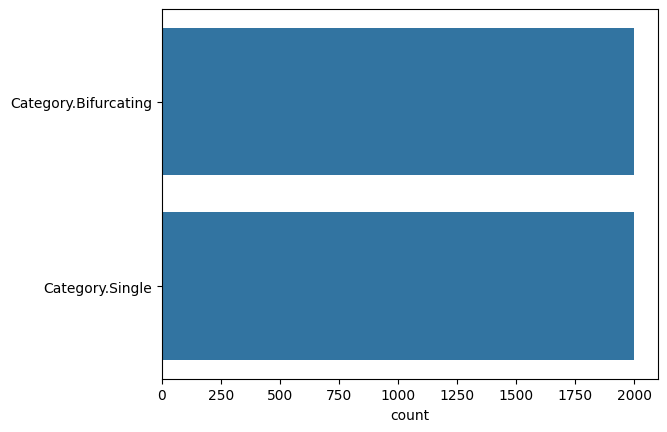

In [4]:
import seaborn as sns
sns.countplot(data.data.label)

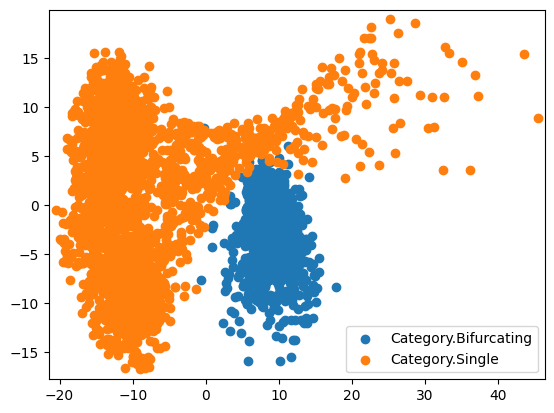

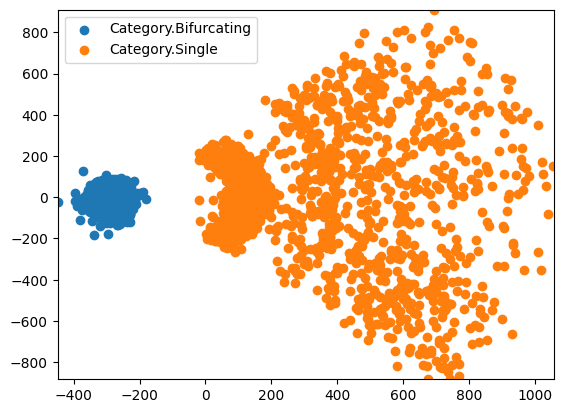

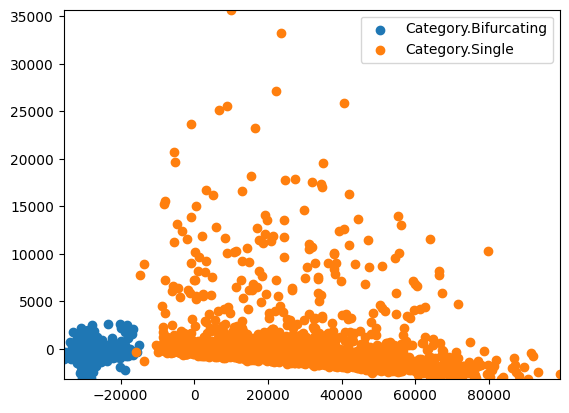

In [5]:
from src.utils.definitions import Feature, Category
from src.utils.plotting import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
plot_data(pos, labels, Category)
plot_data(wss, labels, Category)
plot_data(pressure, labels, Category)

# Performing equivariance check

In [6]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()

batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10]

TestEquivariance.INPUT_DATA = batch

suite = unittest.TestSuite()

suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))

test_runner = unittest.TextTestRunner(verbosity=0)

restResult = test_runner.run(suite)

AttributeError: module 'numba' has no attribute 'generated_jit'

# TODO: analisi dati preliminare. Classi bilanciate? Statistiche sul dataset? Qualche plot figo.

# TODO: HPO

# TODO: Analisi risultati!

In [ ]:
import optuna
from src.trainer import VesselTrainer
from src.models import Gatr
from functools import partial

def objective(trial: optuna.trial.Trial, data: VesselDataModule) -> float:
    # We optimize the number of layers, hidden units in each layer and dropouts.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True) for i in range(n_layers)
    ]

    model = Gatr(gatr_config)
    trainer = VesselTrainer(trainer_config)

    hyperparameters = dict(n_layers=n_layers, dropout=dropout, output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=data)

    return trainer.callback_metrics["val_acc"].item()

pruner = optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
objective = partial(objective, data = data)
study.optimize(objective, n_trials=100, timeout=600)

Testing

In [ ]:
trainer = VesselTrainer(trainer_config)
model = Gatr(gatr_config)
trainer.fit(model, data)

In [ ]:
trainer.test(model, data)

Training Loop

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

trainer = VesselTrainer(trainer_config)

model = BaselineTransformer(baseline_config)

trainer.fit(model, data)

In [ ]:
trainer.test(model, data)

----